In [11]:
from nltk import word_tokenize  
from nltk.stem.snowball import PorterStemmer
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.model_selection import cross_val_score, cross_val_predict, GridSearchCV
import numpy as np
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.pipeline import Pipeline
import warnings
from sklearn.svm import LinearSVC
warnings.filterwarnings('ignore')


Загружаем тренировочную и тестовую выборки

In [12]:
test = pd.read_csv('products_sentiment_test.tsv', sep = '\t',  header = 0)
train = pd.read_csv('products_sentiment_train.tsv', sep = '\t',  header = None, names = ['text', 'y'])
print (train.head())
print (test.head())

                                                text  y
0          2 . take around 10,000 640x480 pictures .  1
1  i downloaded a trial version of computer assoc...  1
2  the wrt54g plus the hga7t is a perfect solutio...  1
3  i dont especially like how music files are uns...  0
4  i was using the cheapie pail ... and it worked...  1
   Id                                               text
0   0  so , why the small digital elph , rather than ...
1   1  3/4 way through the first disk we played on it...
2   2  better for the zen micro is outlook compatibil...
3   3    6 . play gameboy color games on it with goboy .
4   4  likewise , i 've heard norton 2004 professiona...


In [13]:
train_feedback = train['text']
train_labels = train['y']
test_feedback = test[['text']]
test_ids = test[['Id']]

## Мое решение: применим стемминг, попробуем исключить наиболее употребимые слова.

In [18]:
def preprocess(text):
    return text.replace(" 't", " not")
stemmer = PorterStemmer()
analyzer = TfidfVectorizer().build_analyzer()

def stemmed(text):
    return (stemmer.stem(word) for word in analyzer(preprocess(text)))


In [19]:
train['x'] = train.text.apply(preprocess)
test['x'] = test.text.apply(preprocess)
train.head()

,text,y,x
0,"2 . take around 10,000 640x480 pictures .",1,"2 . take around 10,000 640x480 pictures ."
1,i downloaded a trial version of computer assoc...,1,i downloaded a trial version of computer assoc...
2,the wrt54g plus the hga7t is a perfect solutio...,1,the wrt54g plus the hga7t is a perfect solutio...
3,i dont especially like how music files are uns...,0,i dont especially like how music files are uns...
4,i was using the cheapie pail ... and it worked...,1,i was using the cheapie pail ... and it worked...


In [20]:
vectorizer = CountVectorizer()
# составляем корпус документов
corpus = train.x
# подсчитываем
X = vectorizer.fit_transform(corpus)
tfidf_transformer = TfidfTransformer(use_idf=False)
X_train_tfidf = tfidf_transformer.fit_transform(X)

def text_classifier (vectorizer, transformer, classifier):
    return Pipeline(
            [("vectorizer", vectorizer),
             ("transformer", transformer),
            ("classifier", classifier)]
        )

In [21]:
accur = cross_val_score(text_classifier(CountVectorizer(), TfidfTransformer(use_idf=False), LogisticRegression()),  X = corpus, y = train.y, cv = 5).mean()

In [22]:
print(accur)

0.7545043750273439


Попробуем применить другие классификаторы и векторизатор.

In [24]:
for vectorizer in [CountVectorizer,TfidfVectorizer]: 
    for classifier in [LogisticRegression, LinearSVC, SGDClassifier]:
        print(classifier, vectorizer)
        reg_pipeline_svc = Pipeline(
                [("vectorizer", vectorizer()),
                 ("transformer", TfidfTransformer()), ("classifier", classifier())]
            )
        reg_pipeline_svc.fit(corpus, train.y)
        print(cross_val_score(text_classifier(vectorizer(), TfidfTransformer(), classifier()),X = corpus, y = train.y, cv = 5).mean())

<class 'sklearn.linear_model.logistic.LogisticRegression'> <class 'sklearn.feature_extraction.text.CountVectorizer'>
0.7685044312776955
<class 'sklearn.svm.classes.LinearSVC'> <class 'sklearn.feature_extraction.text.CountVectorizer'>
0.7674831655197846
<class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> <class 'sklearn.feature_extraction.text.CountVectorizer'>
0.7579893936837105
<class 'sklearn.linear_model.logistic.LogisticRegression'> <class 'sklearn.feature_extraction.text.TfidfVectorizer'>
0.7625081469259183
<class 'sklearn.svm.classes.LinearSVC'> <class 'sklearn.feature_extraction.text.TfidfVectorizer'>
0.7619831592697454
<class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> <class 'sklearn.feature_extraction.text.TfidfVectorizer'>
0.7529831342695892


 Попробуем удалить стоп-слова

In [25]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /home/olya/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [26]:
stopwords1 = stopwords.words('english')
for vectorizer in [CountVectorizer, TfidfVectorizer]: 
    for classifier in [LogisticRegression, LinearSVC, SGDClassifier]:
        print(classifier, vectorizer)
        reg_pipeline_svc = Pipeline(
                [("vectorizer", vectorizer(stop_words = stopwords1)),
                ("classifier", classifier())]
            )
        reg_pipeline_svc.fit(corpus, train.y)
        print(cross_val_score(text_classifier(vectorizer(stop_words = stopwords1), TfidfTransformer(), classifier()),X = corpus, y = train.y, cv = 5).mean())

<class 'sklearn.linear_model.logistic.LogisticRegression'> <class 'sklearn.feature_extraction.text.CountVectorizer'>
0.7480068937930862
<class 'sklearn.svm.classes.LinearSVC'> <class 'sklearn.feature_extraction.text.CountVectorizer'>
0.7449968749804686
<class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> <class 'sklearn.feature_extraction.text.CountVectorizer'>
0.7445018750117187
<class 'sklearn.linear_model.logistic.LogisticRegression'> <class 'sklearn.feature_extraction.text.TfidfVectorizer'>
0.7324943374646093
<class 'sklearn.svm.classes.LinearSVC'> <class 'sklearn.feature_extraction.text.TfidfVectorizer'>
0.7435031218945118
<class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> <class 'sklearn.feature_extraction.text.TfidfVectorizer'>
0.7354980906130664


Удаление стоп-слов привело к снижению точности, поэтому не будем его использовать.
Попробуем использовать регуляризаторы и подберем лучшие параметры через сетку.

In [27]:
modelNGr = text_classifier(CountVectorizer(ngram_range = (1,3)), TfidfTransformer(use_idf=False), LogisticRegression()).fit(corpus, train.y)
modelNgrcorr = text_classifier(TfidfVectorizer(ngram_range = (1,3)), TfidfTransformer(use_idf=False), SGDClassifier(loss='log', penalty='l2', alpha=1e-5, max_iter = 5)).fit(corpus, train.y)
accurNGr = cross_val_score(modelNGr,  X = corpus, y = train.y, cv = 5).mean()
accurNGrcorr = cross_val_score(modelNgrcorr,  X = corpus, y = train.y, cv = 5).mean()
print(accurNGr, accurNGrcorr)

0.7445056094100588 0.7894807092544328


Попробуем добавить биграммы и функцию потерь в классификатор

In [28]:
modelNGr = text_classifier(TfidfVectorizer(ngram_range = (1,3)),  TfidfTransformer(use_idf=False), SGDClassifier()).fit(corpus, train.y)
modelNgrcorr = text_classifier(TfidfVectorizer(ngram_range = (1,3)),  TfidfTransformer(use_idf=True), SGDClassifier(loss='log', penalty='l2', alpha=1e-5, max_iter = 5)).fit(corpus, train.y)
accurNGr = cross_val_score(modelNGr,  X = corpus, y = train.y, cv = 5).mean()
accurNGrcorr = cross_val_score(modelNgrcorr,  X = corpus, y = train.y, cv = 5).mean()
print(accurNGr, accurNGrcorr)

0.7894794873717961 0.7794819436371477


In [31]:
text_clf = Pipeline([('vect', TfidfVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', SGDClassifier(loss='hinge', penalty='l2',
                                           alpha=1e-3, max_iter=5)),
])

In [32]:
parameters = {'vect__ngram_range': [(1, 1), (1, 2), (1, 3)],
              'tfidf__use_idf': (True, False),
              'clf__alpha': (1e-3, 1e-5),
              'clf__loss': ('hinge','log'),
              'clf__penalty': ('l1','l2'),
}
gs_clf = GridSearchCV(text_clf, parameters, n_jobs=-1)

In [33]:
gs_clf = gs_clf.fit(corpus, train.y)

In [34]:
print(gs_clf.best_estimator_)
print(gs_clf.best_score_)

Pipeline(memory=None,
         steps=[('vect',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 3), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(...
                ('clf',
                 SGDClassifier(alpha=1e-05, average=False, class_weight=None,
                               early_stopping=False, epsilon=0.1, eta0=0.0,
                               fit_intercept=True, l1_ratio=0.15,
                               learning_rate='optimal', lo

Лучший вариант - TfidfVectorizer(ngram_range = (1,3)),  TfidfTransformer(use_idf=False), SGDClassifier() - подбор параметров дал более низкую точность.

Применим итоговую модель: TfidVectorizer+SGDClassifier к тестовой выборке и получим предсказания

In [29]:
test['y'] = modelNGr.predict(test.text)
test[['Id','y']].to_csv('product-reviews-sentiment-analysis-light.csv', index = False)

Проверим формат файла

In [30]:
! head -5 product-reviews-sentiment-analysis-light.csv

Id,y
0,1
1,0
2,1
3,1


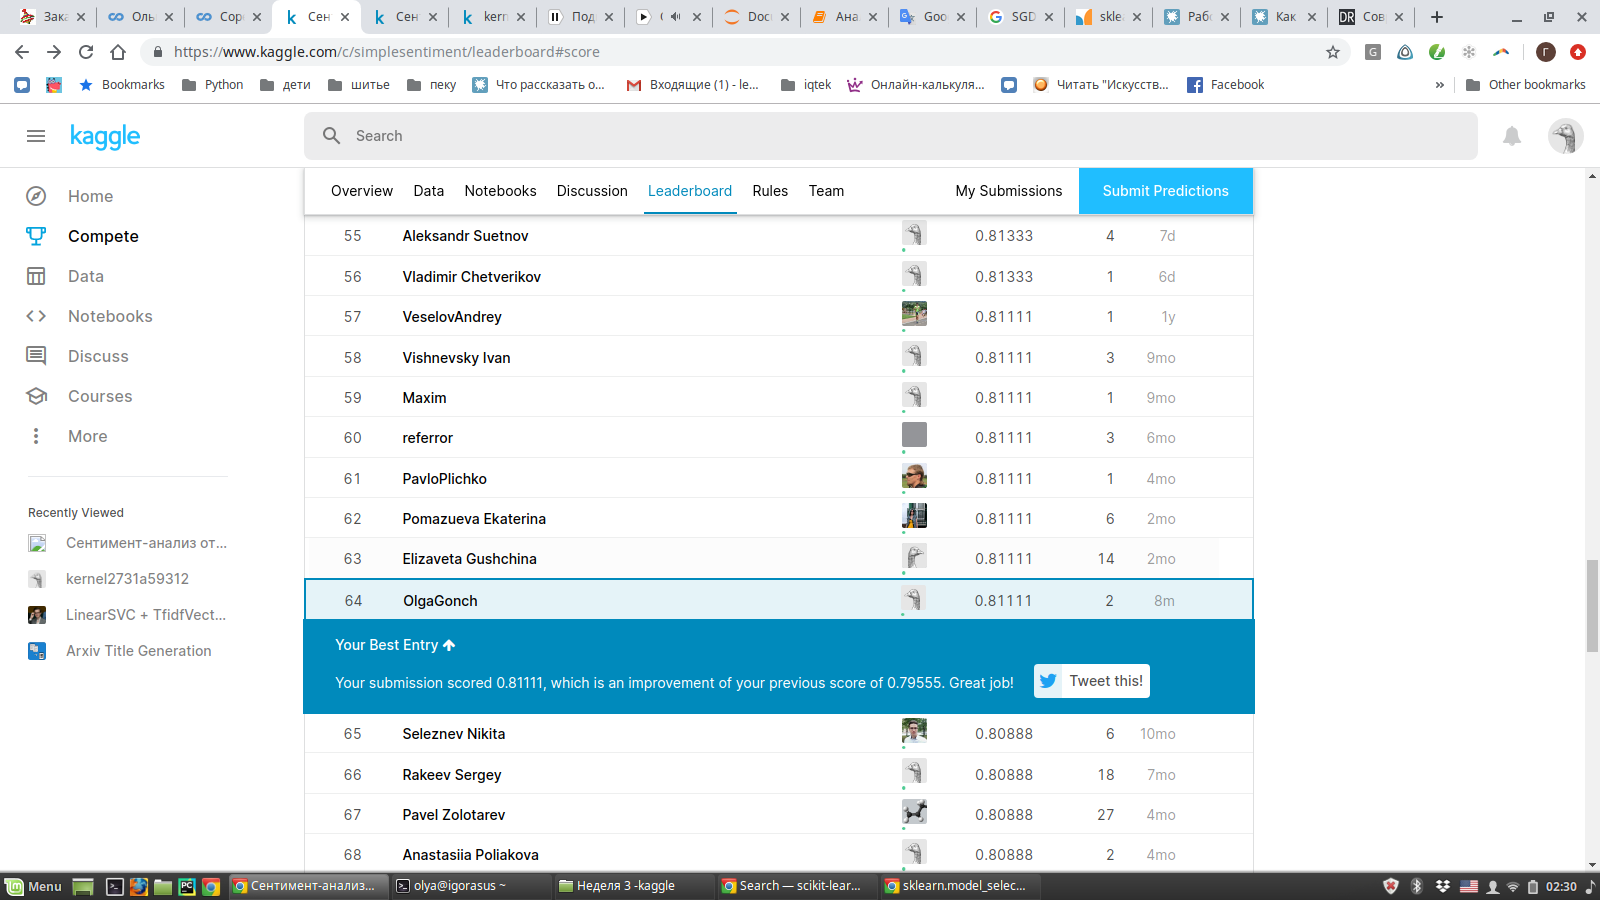